In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import subprocess; FOLDER_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
import warnings; warnings.filterwarnings("ignore")
import sys, os; sys.path.append(os.path.dirname(f'{FOLDER_PATH}/scripts'))

In [14]:
from scripts.helpers import read_data, split_data, WindowGenerator, compile_and_fit
from tensorflow.keras import models, layers
import tensorflow as tf

In [6]:
df = read_data(generate_speed_angle=True)
train_df_np, valid_df_np, test_df_np = split_data(df, scaler="minmax")

Train start and end dates:  2019-01-24 03:00:00 2021-06-21 23:00:00
Validation start and end dates:  2021-06-22 00:00:00 2021-10-09 23:00:00
Test start and end dates:  2021-10-10 00:00:00 2022-01-27 23:00:00


In [7]:
OUT_STEPS = 24

columns = [col for col in df.columns if col != "rt_plant_id"]

multi_window = WindowGenerator(train_df=train_df_np, valid_df=valid_df_np, test_df=test_df_np, columns=columns,input_width=120, label_width=24, shift=0, label_columns=["production"])
multi_window

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): ['production']

2022-04-16 15:36:27.092693: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-16 15:36:27.092713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (algopoly): /proc/driver/nvidia/version does not exist
2022-04-16 15:36:27.097825: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


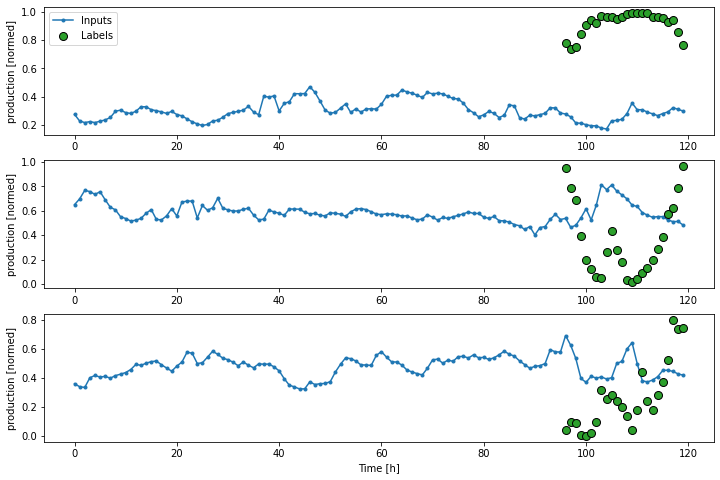

In [8]:
multi_window.plot(plant=0)

In [ ]:
corr = pd.pivot_table(df[["rt_plant_id", "production"]].reset_index(), index="forecast_dt", columns="rt_plant_id", values="production").corr()
corr

In [ ]:
OUT_STEPS = 24

columns = [col for col in df.columns if col != "rt_plant_id"]

multi_window = WindowGenerator(train_df=train_df_np, valid_df=valid_df_np, test_df=test_df_np, columns=columns,input_width=120, label_width=24, shift=0, label_columns=["production"])
multi_window

In [ ]:
multi_window.plot(plant=0)

In [ ]:
multi_val_performance = {}
multi_performance = {}

## Dense

### Linear

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,3,1)))
model.add(layers.Dense(32, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Dense(16))
model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['Linear'] = model.evaluate(multi_window.valid)
multi_performance['Linear'] = model.evaluate(multi_window.test)

multi_window.plot(model, plant=0, max_subplots=5)

### Linear2

In [15]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Dropout(0.2))
model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_1 (Permute)         (None, 94, 120, 16)       0         
                                                                 
 dense (Dense)               (None, 94, 120, 24)       408       
                                                                 
 dropout (Dropout)           (None, 94, 120, 24)       0         
                                                                 
 reshape (Reshape)           (None, 94, 2880)          0         
                                                                 
 dense_1 (Dense)             (None, 94, 24)            69144     
                                                                 
 permute_2 (Permute)         (None, 24, 94)            0         
                                                                 
 reshape_1 (Reshape)         (None, 24, 94, 1)        

In [17]:
history = compile_and_fit(model, multi_window, patience=2, max_epochs=5, loss="mse", optimizer="rmsprop")

Epoch 1/5
329/329 [==============================] - 50s 149ms/step - loss: 0.0555 - mae: 0.1804 - wmape: 0.5156 - val_loss: 0.0829 - val_mae: 0.2166 - val_wmape: 0.5145
Epoch 2/5
329/329 [==============================] - 53s 161ms/step - loss: 0.0539 - mae: 0.1780 - wmape: 0.5087 - val_loss: 0.0503 - val_mae: 0.1789 - val_wmape: 0.4260
Epoch 3/5
329/329 [==============================] - 52s 158ms/step - loss: 0.0536 - mae: 0.1771 - wmape: 0.5063 - val_loss: 0.0505 - val_mae: 0.1803 - val_wmape: 0.4297
Epoch 4/5
329/329 [==============================] - 50s 152ms/step - loss: 0.0534 - mae: 0.1766 - wmape: 0.5044 - val_loss: 0.0497 - val_mae: 0.1740 - val_wmape: 0.4141
Epoch 5/5
329/329 [==============================] - 51s 153ms/step - loss: 0.0531 - mae: 0.1761 - wmape: 0.5030 - val_loss: 0.0633 - val_mae: 0.2116 - val_wmape: 0.5031


40/40 [==============================] - 2s 45ms/step - loss: 0.0756 - mae: 0.2248 - wmape: 0.5371


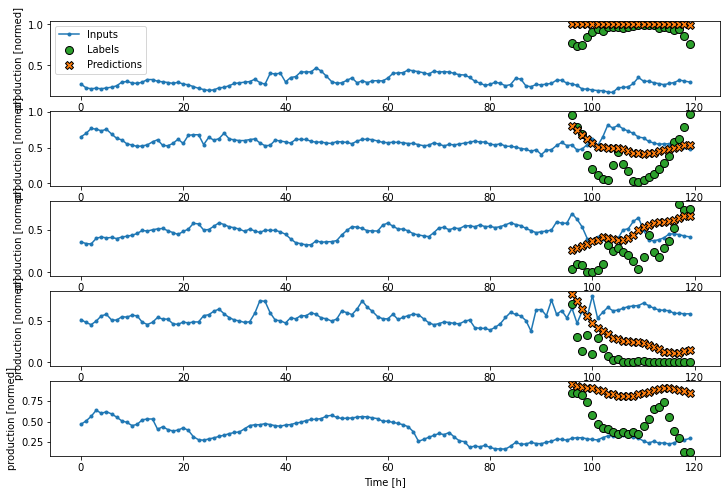

In [19]:
multi_val_performance, multi_performance = {}, {}

multi_val_performance['Linear'] = model.evaluate(multi_window.valid)
multi_performance['Linear'] = model.evaluate(multi_window.test)

multi_window.plot(model, plant=0, max_subplots=5)

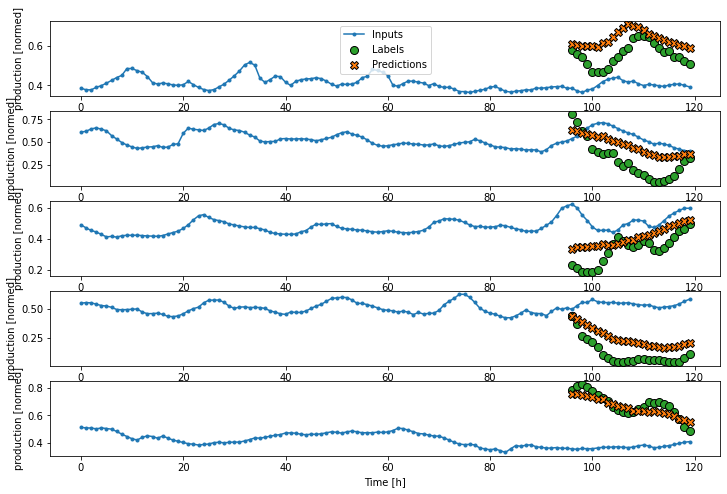

In [20]:
multi_window.plot(model, max_subplots=5)

### Conv4

In [ ]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min', 
        verbose=1,
        restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), wmape]) 
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.valid,
                        verbose=1,
                        callbacks=[early_stopping])
    return history

In [ ]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.Permute((2,1,3)))
model.add(layers.Conv2D(64, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))
model.add(layers.Conv2D(32, CONV_WIDTH, activation="relu", padding="same"))
model.add(layers.Permute((2,3,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Permute((3,1,2)))
model.add(layers.Reshape([multi_window.number_of_plants, -1]))
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))

model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)

In [ ]:
multi_val_performance['CNN'] = model.evaluate(multi_window.valid)
multi_performance['CNN'] = model.evaluate(multi_window.test)

multi_window.plot(model, plant=0, max_subplots=5)

### ConvLSTM

In [ ]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min', 
        verbose=1,
        restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(), wmape]) 
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.valid,
                        verbose=1,
                        callbacks=[early_stopping])
    return history

In [ ]:
CONV_WIDTH = 5

model = models.Sequential()
model.add(layers.InputLayer(input_shape=multi_window.input_shape))
model.add(layers.ConvLSTM1D(24, CONV_WIDTH, activation="tanh", padding="same"))
# model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Permute((2,1)))
model.add(layers.Reshape([OUT_STEPS, multi_window.number_of_plants, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window)